In [324]:
import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn import model_selection
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import Binarizer, LabelEncoder, MaxAbsScaler, MinMaxScaler, OneHotEncoder, \
    OrdinalEncoder, RobustScaler, StandardScaler

# Exercise 2 - Debugging - Drugs

The dataset contains a set of patients, all of whom suffered from the same illness.
During their course of treatment, each patient responded to one of 5 medications: Drug A, Drug B, Drug c, Drug x or y.

This complex dataset proposes a set of challenges that you'll try to overcome. A basic ML pipeline is already in place. You have to optimize the performance of the model by applying good practices, debugging pre-processing errors, etc.

**Rules**:
- Do not use other modules than those already imported *(or do it only if your own code is not working. In this case, keep your own code in the notebook, commented, so that we know what you tried)*.
- Explain **all** of your choices. For every task, choose the most appropriate option for this problem and describe your choice.
- You can modify any parts of the code or replace the model by one already used in previous PWs.

**Work to do**:
- [ ] Apply a type of normalization.
- [ ] Encode categorical data.
- [ ] Use all columns in the dataset (or choose the most meaningful features).
- [ ] Choose a more appropriate metric.
- [ ] Optimize hyper-parameters.
- [ ] Test the model performance correctly using a separated test set.
- Apply **two** of those techniques:
  - [ ] Keep relative class frequencies in the train/test sets (check train_test_split docs)
  - [ ] Show which feature(s) are the most correlated to the target.
  - [ ] Use cross-validation.

In [325]:
df = pd.read_csv("drug.csv")
df.head()

,age,sex,bp,cholesterol,Na_to_K,drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


In [326]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          200 non-null    int64  
 1   sex          200 non-null    object 
 2   bp           200 non-null    object 
 3   cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


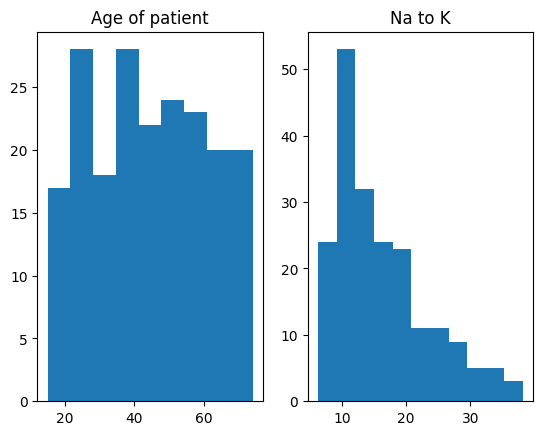

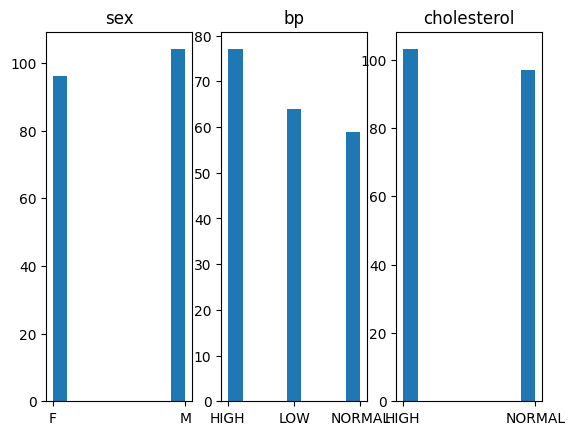

In [327]:
import matplotlib.pyplot as plt
categorical_columns = ["sex", "bp", "cholesterol"]
# Check float values in data
plt.figure()
plt.subplot(1,2,1)
plt.hist(df['age'],bins='auto')
plt.title('Age of patient')
plt.subplot(1,2,2)
plt.hist(df['Na_to_K'],bins='auto')
plt.title('Na to K')
plt.figure()
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.hist(df[categorical_columns[i]],bins='auto')
    plt.title(categorical_columns[i])

**Age of patient**\
No outliers with min and max knows : *Min-max resacling*\
**Na to K**\
Not a lot of outliers : *z-norm*\
**Encode categorical class**\
The vocabulary are low level and not a lot of word : *Hot 1*

In [328]:
categorical_columns = ["sex", "bp", "cholesterol"]

# TODO: you will replace this by a more adapted preprocessing step
#Encode word
enc = OneHotEncoder(sparse=False)
wd_enc = enc.fit_transform(df[categorical_columns])
# Convert the result back into a dataframe and add column names
one_hot_df = pd.DataFrame(wd_enc, columns=enc.get_feature_names_out(categorical_columns))
# Drop the original categorical columns from original df, and merge the new one-hot columns
data = df.drop(categorical_columns, axis=1)
data = pd.concat([data, one_hot_df], axis=1)
data.head()


c:\Users\olivi\master\machlearn\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,age,Na_to_K,drug,sex_F,sex_M,bp_HIGH,bp_LOW,bp_NORMAL,cholesterol_HIGH,cholesterol_NORMAL
0,23,25.355,drugY,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,47,13.093,drugC,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,47,10.114,drugC,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,28,7.798,drugX,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,61,18.043,drugY,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [329]:
#df = df.drop(columns=["sex", "bp", "cholesterol"])
data['age'] = MinMaxScaler().fit_transform(df[['age']])

data['Na_to_K']  =StandardScaler().fit_transform(df[['Na_to_K'] ])

In [330]:
X = data.drop(columns="drug")
y = data["drug"]

In [331]:
# split data in 80% (test & validation set) & 20%
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# split data in 80% & 20% -> reality 60% (train set), 20% (validation set) & 20% (test set)
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.2, random_state=42)

**Hyperparameter**:\
In knn they have 3 hyperparamters :
- Nbr neighbors
- Weight
- p

to define these values, we need to compare F1 of the train set and validation set after modification of hyperparamteres

In [332]:
# TODO: a preprocessing step is likely missing here...

hParam = {
    "n_neighbors": [2, 5, 8, 11],
    "weights": ["uniform", "distance"],
    "p_distance": [1, 2]
    }
F1_best  = 0
best_param = {}
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
# F1 on train set 
y_pred = knn.predict(X_train)
F1_train = metrics.f1_score(y_train,y_pred,average='weighted')
for n in hParam["n_neighbors"]:
    for w in hParam["weights"]:
        for p in hParam["p_distance"]:
            #def new parameter

            knn = KNeighborsClassifier(n_neighbors=n,weights=w,p=p)
            knn.fit(X_val, y_val)
            
            # F1 on validation set 
            y_pred = knn.predict(X_val)
            F1_val = metrics.f1_score(y_val,y_pred,average='weighted')
            # verifiy if better 
            if F1_val > F1_train:
                F1_best = F1_val
                best_param = {
                    "n_neighbors": n,
                    "weights": w,
                    "p_distance": p}
                
print(f'Best param :{best_param}')

Best param :{'n_neighbors': 11, 'weights': 'distance', 'p_distance': 2}


In [333]:
#use best parameter to the project
n = best_param['n_neighbors']
w = best_param['weights']
p = best_param['p_distance']
knn = KNeighborsClassifier(n_neighbors=n,weights=w,p=p)
knn.fit(X_test, y_test)

KNeighborsClassifier(n_neighbors=11, weights='distance')

**Metric**:\
The best choice seem to show F1 to see recall and precisison too.\

In [334]:
def predict(estimator, X, y):
    # predict
    y_pred = estimator.predict(X)
    
    # show confusion matrix
    cm = confusion_matrix(y, y_pred)
    disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=estimator.classes_)
    disp.plot();
    
    # check metric (this one is probably not the best choice...)
    accuracy = metrics.accuracy_score(y, y_pred)
    metric = metrics.f1_score(y,y_pred,average='weighted')
    
    print(f"F1-score: {metric}, accuracy = {accuracy}")

F1-score: 1.0, accuracy = 1.0


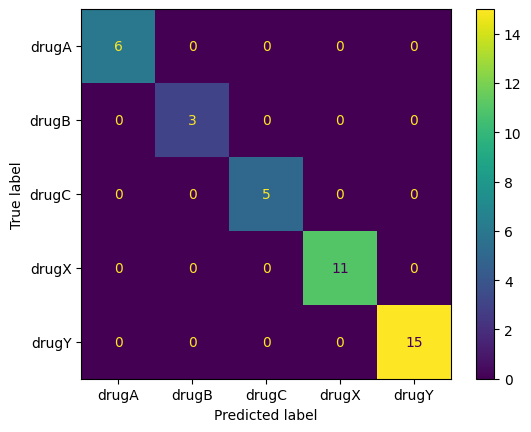

In [335]:
predict(knn, X_test, y_test)

In [336]:
# TODO: any of the 3 proposed task...

**Two technique:**\
The results are satisfied and use cross-validation to find best hyperparameters.
We will test to find the most correlate feature.

In [337]:
print(data.columns)

Index(['age', 'Na_to_K', 'drug', 'sex_F', 'sex_M', 'bp_HIGH', 'bp_LOW',
       'bp_NORMAL', 'cholesterol_HIGH', 'cholesterol_NORMAL'],
      dtype='object')


In [338]:
X = data.drop(columns="drug")
y = data["drug"]
# split data in 80% (test & validation set) & 20%
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# split data in 80% & 20% -> reality 60% (train set), 20% (validation set) & 20% (test set)
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.2, random_state=42)

In [339]:
hParam = {
    "n_neighbors": [2, 5, 8, 11],
    "weights": ["uniform", "distance"],
    "p_distance": [1, 2]
    }


In [340]:
F1_best  = 0
best_param = {}
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
# F1 on train set 
y_pred = knn.predict(X_train)
F1_train = metrics.f1_score(y_train,y_pred,average='weighted')
for c in data.columns:
    X = data.drop(columns = c)
    #print(X.head())
    
    y = data[c]
    # split data in 80% (test & validation set) & 20%
    X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # split data in 80% & 20% -> reality 60% (train set), 20% (validation set) & 20% (test set)
    X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.2, random_state=42)
    for n in hParam["n_neighbors"]:
        for w in hParam["weights"]:
            for p in hParam["p_distance"]:
                print('test')
                #def new parameter

                knn = KNeighborsClassifier(n_neighbors=n,weights=w,p=p)
                knn.fit(X_val, y_val)
                
                # F1 on validation set 
                # y_pred = knn.predict(X_val)
                # F1_val = metrics.f1_score(y_val,y_pred,average='weighted')
                # verifiy if better 
    #             if F1_val > F1_train:
    #                 F1_best = F1_val
    #                 data_drop = c
    #                 best_param = {
    #                     "n_neighbors": n,
    #                     "weights": w,
    #                     "p_distance": p}

test


ValueError: could not convert string to float: 'drugX'

In [289]:
predict(knn, X_test, y_test)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- drug
Feature names seen at fit time, yet now missing:
- cholesterol_NORMAL
